In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data_utils
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
class MLP_Deep_Wide(nn.Module):
    def __init__(self):
        super(MLP_Deep_Wide, self).__init__()
        # Increase the width of the layers
        self.fc1 = nn.Linear(3 * 32 * 32, 256)  # First hidden layer with more neurons
        self.fc2 = nn.Linear(256, 256)          # Second hidden layer with more neurons
        self.fc3 = nn.Linear(256, 128)          # Third hidden layer with more neurons
        self.fc4 = nn.Linear(128, 128)          # Additional layer
        self.fc5 = nn.Linear(128, 64)           # Additional layer
        self.fc6 = nn.Linear(64, 10)            # Output layer

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x


In [5]:
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1) / 255 for image in images])
    labels = torch.tensor(labels)
    return images, labels

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

trainloader = data_utils.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate_fn)
testloader = data_utils.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate_fn)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
print(f'Using device: {device}')

Using device: cuda:0


In [11]:
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []

net_deep_wide = MLP_Deep_Wide().to(device)  # Make sure to instantiate your new model
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_deep_wide.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    net_deep_wide.train()  # Use net_deep_wide here
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net_deep_wide(inputs)  # And here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    # Validation
    net_deep_wide.eval()  # And here
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net_deep_wide(images)  # And here
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    validation_loss = val_loss / len(testloader)
    validation_accuracy = 100 * correct / total
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f'Epoch {epoch + 1}, Training Loss: {training_loss}, Validation Loss: {validation_loss}, Training Accuracy: {training_accuracy}%, Validation Accuracy: {validation_accuracy}%')

print('Finished Training')
torch.save(net_deep_wide.state_dict(), './mlp_deep_wide_cifar10.pth')  # And finally here

Epoch 1, Training Loss: 2.0415701713991163, Validation Loss: 1.8939982120275498, Training Accuracy: 23.048%, Validation Accuracy: 29.94%
Epoch 2, Training Loss: 1.7769428820037843, Validation Loss: 1.6890341357469558, Training Accuracy: 35.126%, Validation Accuracy: 38.79%
Epoch 3, Training Loss: 1.6696841041636468, Validation Loss: 1.5884823351621629, Training Accuracy: 39.734%, Validation Accuracy: 42.66%
Epoch 4, Training Loss: 1.5988044646275044, Validation Loss: 1.5808177944064141, Training Accuracy: 42.55%, Validation Accuracy: 43.17%
Epoch 5, Training Loss: 1.5379924109637737, Validation Loss: 1.5144357711791991, Training Accuracy: 44.748%, Validation Accuracy: 46.18%
Epoch 6, Training Loss: 1.4905669991528987, Validation Loss: 1.4901326744794845, Training Accuracy: 46.64%, Validation Accuracy: 46.89%
Epoch 7, Training Loss: 1.4508562263166904, Validation Loss: 1.4631019559919833, Training Accuracy: 47.89%, Validation Accuracy: 48.2%
Epoch 8, Training Loss: 1.4141508277016879, V

Precision: 0.53471092827414
Recall: 0.5223
F1 Score: 0.5209628719964627


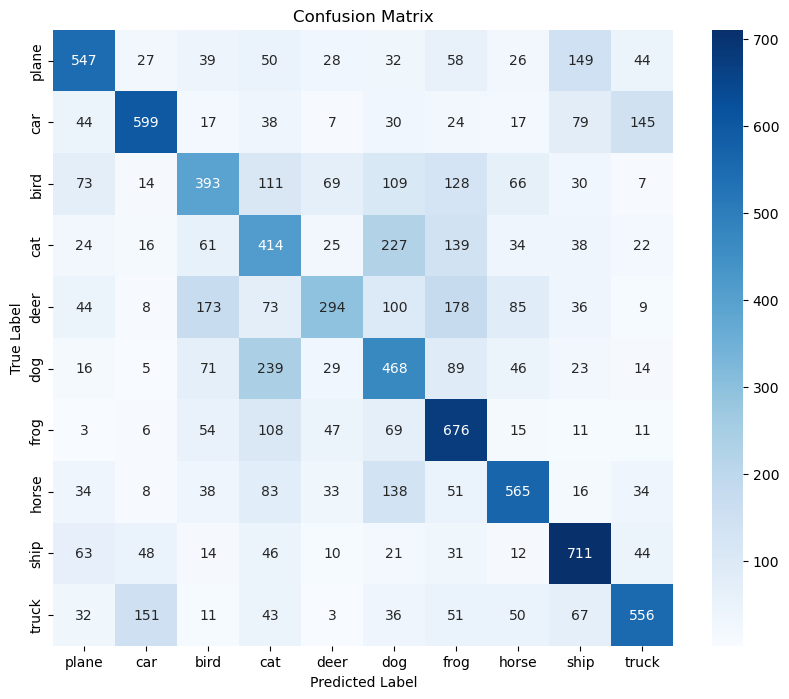

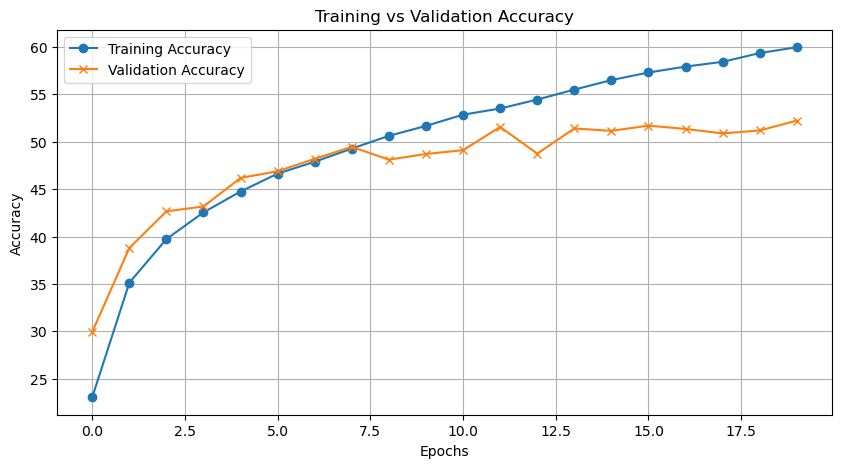

In [14]:
import seaborn as sns

# Assuming your model is already trained and you have saved the state dict
net_deep_wide = MLP_Deep_Wide()  # Instantiate your model
net_deep_wide.load_state_dict(torch.load('./mlp_deep_wide_cifar10.pth'))  # Load the trained parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_deep_wide.to(device)

# Define the class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set the model to evaluation mode
net_deep_wide.eval()

# Initialize lists to collect true labels and predictions
all_preds = []
all_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    for data in testloader:  # Make sure testloader is defined and loads CIFAR-10 test data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_deep_wide(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# Print precision, recall, and F1 score
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot 'Training vs Validation Accuracy'
plt.figure(figsize=(10, 5))
plt.plot(training_accuracies, label='Training Accuracy', marker='o')
plt.plot(validation_accuracies, label='Validation Accuracy', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
